In [2]:
!pip install datasets albumentations opencv-python pytorch-lightning torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 47.8 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1", split="train")
print("dataset:", dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/782 [00:00<?, ?B/s]

data/train-00000-of-00001-76ffc8319f74dd(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/test-00000-of-00001-af2d92d1cee2851(…):   0%|          | 0.00/18.8M [00:00<?, ?B/s]

data/valid-00000-of-00001-894b4e1f736b57(…):   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/125 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/70 [00:00<?, ? examples/s]

dataset: Dataset({
    features: ['image', 'id', 'parsed_data', 'raw_data'],
    num_rows: 2043
})


In [17]:
import json

def prepare_dbnet(example):
    raw = json.loads(example["raw_data"])
    #print("raw:", raw)
    boxes = eval(raw["ocr_boxes"])
    #print("boxes:", boxes)

    polygons = []
    for box, (text, conf) in boxes:
        flat = []
        for point in box:
            flat += [point[0], point[1]]
        polygons.append({"text": text, "poly": flat})

    example["polygons"] = polygons
    #print("polygons:", polygons)
    return example

dataset = dataset.map(prepare_dbnet)


Map:   0%|          | 0/2043 [00:00<?, ? examples/s]

In [7]:
import torch.nn as nn
import torchvision.models as models

'''load a pretrained ResNet18.
This network is great at extracting visual features: edges, curves, strokes, shapes, text-like patterns Because it was trained on ImageNet.'''

class DBNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Keep only convolutional layers
        self.backbone = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4
        )
        self.conv = nn.Conv2d(512, 64, kernel_size=1)  # 512 for ResNet18
        self.binarize = nn.Conv2d(64, 1, 3, padding=1)  # raw logits

    def forward(self, x):
        f = self.backbone(x)  # [B, 512, H/32, W/32]
        f = self.conv(f)
        prob_map = self.binarize(f)
        return prob_map


In [8]:
import torch.nn as nn

# Loss function for DBNet
db_loss = nn.BCEWithLogitsLoss()


In [9]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import torch.nn.functional as F

# Image transform
transform = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.ToTensor()
])

# Create mask
def create_mask_from_polygons(polygons, image_size):
    """
    polygons: list of polygons (each polygon is list of points [x, y])
    image_size: (width, height)
    """
    mask = Image.new("L", image_size, 0)
    draw = ImageDraw.Draw(mask)
    for poly in polygons:
        draw.polygon(poly, fill=255)
    mask = np.array(mask)/255.0
    return torch.tensor(mask, dtype=torch.float32)




In [10]:
import torch.nn.functional as F

class DBNetDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds

        # target size (H, W) because torchvision.Resize takes (height, width)
        self.target_h = 640
        self.target_w = 480

        self.transform = transforms.Compose([
            transforms.Resize((self.target_h, self.target_w)),  # (H, W)
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        ex = self.ds[idx]
        pil_img = ex["image"]              # original PIL image

        # original size from dataset (width, height)
        orig_w, orig_h = pil_img.size

        # 1) Resize image
        img = self.transform(pil_img)      # [3, 640, 480]

        # 2) Scale factors from original → resized
        sx = self.target_w / orig_w       # scale for x (width)
        sy = self.target_h / orig_h       # scale for y (height)

        # 3) Extract and SCALE polygons
        polygons_raw = [p["poly"] for p in ex.get("polygons", [])]
        scaled_polygons = []
        for poly in polygons_raw:
            scaled = []
            xs = poly[0::2]
            ys = poly[1::2]
            for x, y in zip(xs, ys):
                scaled_x = x * sx
                scaled_y = y * sy
                scaled += [scaled_x, scaled_y]
            scaled_polygons.append(scaled)

        # 4) Create mask on resized image size (width, height)
        # full-resolution GT mask (NO DOWNSCALE)
        mask = create_mask_from_polygons(
            scaled_polygons,
            (self.target_w, self.target_h)  # (width, height)
        )                                  # -> [H, W]
        mask = mask.unsqueeze(0)           # [1, H, W] for channel dim

        return img, mask                   # img: [3,H,W], mask: [1,H,W]

    def __len__(self):
        return len(self.ds)


train_loader = torch.utils.data.DataLoader(
    DBNetDataset(dataset),
    batch_size=2,
    shuffle=True,
    num_workers=0,   # safer in Colab
    pin_memory=True
)


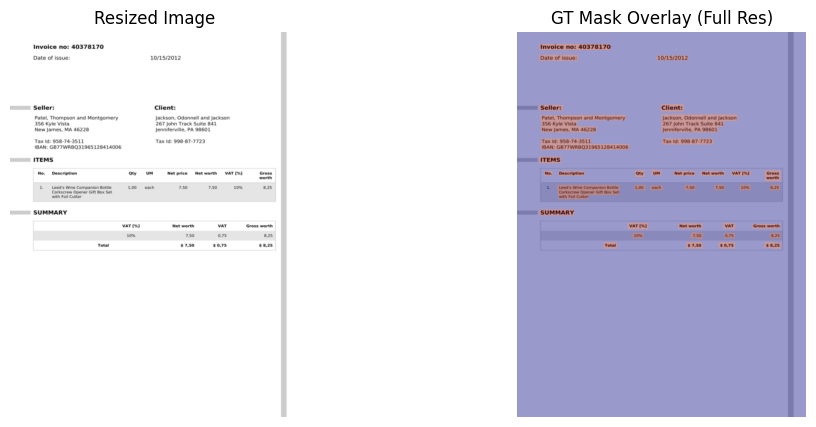

In [12]:
import matplotlib.pyplot as plt

ds = DBNetDataset(dataset)   # using the new full-res version
ex_img, ex_mask = ds[0]      # ex_mask: [1, H, W]

mask_up = ex_mask[0].cpu().numpy()  # already full size [H, W]
img_np = ex_img.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Resized Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("GT Mask Overlay (Full Res)")
plt.imshow(img_np)
plt.imshow(mask_up, cmap="jet", alpha=0.4)
plt.axis("off")

plt.show()


In [10]:
import torch
from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# 1. Recreate the same DBNet architecture
model = DBNet().to(device)

# 2. Mount Drive to access saved weights
drive.mount('/content/drive')

# 3. Load the saved weights
state_dict = torch.load("/content/drive/MyDrive/dbnet_invoice_epoch10.pth",
                        map_location=device)
model.load_state_dict(state_dict)

model.eval()  # put in inference mode
print("✅ Loaded trained DBNet model from saved weights.")


Using: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded trained DBNet model from saved weights.


In [14]:
import time
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = DBNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scaler = GradScaler()

# Get target size from dataset (should be 640 x 480)
H = train_loader.dataset.target_h
W = train_loader.dataset.target_w

for epoch in range(10):  # train for 10 epochs
    start_time = time.time()
    epoch_loss = 0.0

    model.train()

    for batch_i, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.to(device, non_blocking=True)    # [B, 3, H, W]
        masks = masks.to(device, non_blocking=True)  # [B, 1, H, W]

        optimizer.zero_grad()

        with autocast():
            preds = model(imgs)  # [B, 1, H/32, W/32]

            # 🔴 important: upsample preds to full-res mask size
            preds_up = F.interpolate(
                preds,
                size=(H, W),      # (640, 480)
                mode="bilinear",
                align_corners=False
            )                    # [B, 1, H, W]

            loss = db_loss(preds_up, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch} | Avg Loss: {epoch_loss:.4f} | Time: {epoch_time:.2f}s")

# === SAVE TRAINED MODEL LOCALLY (after training loop) ===
torch.save(model.state_dict(), "dbnet_invoice_epoch10.pth")
print("Model weights saved to dbnet_invoice_epoch10.pth")

# (Optional) also store it in Google Drive
from google.colab import drive
drive.mount('/content/drive')

!cp dbnet_invoice_epoch10.pth "/content/drive/MyDrive/dbnet_invoice_epoch10.pth"
print("Model copied to Drive: /content/drive/MyDrive/dbnet_invoice_epoch10.pth")


Using: cuda


/tmp/ipython-input-2999349448.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2999349448.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 0 | Avg Loss: 0.2096 | Time: 90.11s
Epoch 1 | Avg Loss: 0.1870 | Time: 88.20s
Epoch 2 | Avg Loss: 0.1808 | Time: 91.05s
Epoch 3 | Avg Loss: 0.1762 | Time: 89.82s
Epoch 4 | Avg Loss: 0.1715 | Time: 90.22s
Epoch 5 | Avg Loss: 0.1670 | Time: 90.42s
Epoch 6 | Avg Loss: 0.1636 | Time: 89.49s
Epoch 7 | Avg Loss: 0.1611 | Time: 90.97s
Epoch 8 | Avg Loss: 0.1586 | Time: 90.46s
Epoch 9 | Avg Loss: 0.1573 | Time: 91.61s
Model weights saved to dbnet_invoice_epoch10.pth
Mounted at /content/drive
Model copied to Drive: /content/drive/MyDrive/dbnet_invoice_epoch10.pth


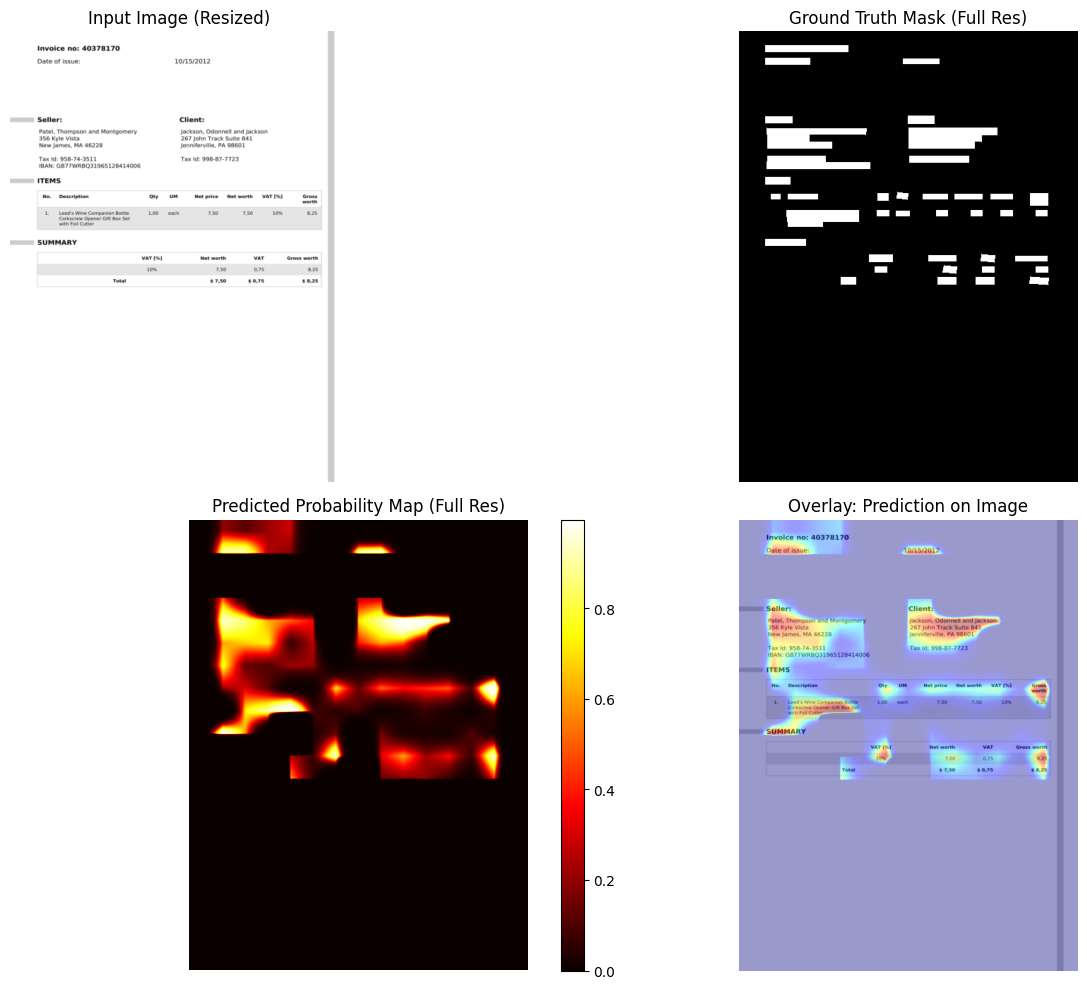

In [16]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Make sure model is in eval mode
model.eval()

# Use the same dataset instance used in training
vis_dataset = train_loader.dataset

# Pick one example (you can change the index)
idx = 0
img, gt_mask = vis_dataset[idx]   # img: [3, H, W], gt_mask: [1, H, W]

# Prepare for model
img_batch = img.unsqueeze(0).to(device)    # [1, 3, H, W]
gt_mask = gt_mask.unsqueeze(0).to(device)  # [1, 1, H, W]

H, W = img.shape[1], img.shape[2]          # 640, 480

with torch.no_grad():
    pred_logits = model(img_batch)         # [1, 1, H/32, W/32]

    # 🔴 upsample logits to full resolution (same as in training)
    pred_logits_up = F.interpolate(
        pred_logits,
        size=(H, W),
        mode="bilinear",
        align_corners=False
    )                                      # [1, 1, H, W]

    pred_prob = torch.sigmoid(pred_logits_up)[0, 0].cpu().numpy()  # [H, W]

# Ground truth mask as numpy
gt_np = gt_mask[0, 0].cpu().numpy()        # [H, W]

# Convert image tensor to numpy for plotting
img_np = img.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]

# Plot everything
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.title("Input Image (Resized)")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Ground Truth Mask (Full Res)")
plt.imshow(gt_np, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Predicted Probability Map (Full Res)")
plt.imshow(pred_prob, cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Overlay: Prediction on Image")
plt.imshow(img_np)
plt.imshow(pred_prob, cmap="jet", alpha=0.4)
plt.axis("off")

plt.tight_layout()
plt.show()
